# Import packages

In [82]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm

## Load Data

In [83]:
df = pd.read_excel("C:\\Users\\u23e00\\Downloads\\Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.**

In [84]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have 4-years of furniture sales data

In [85]:
# Indexing with Time Series Data

furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2016-11-08', '2016-11-08', '2015-10-11', '2014-06-09',
               '2014-06-09', '2017-07-16', '2015-09-25', '2015-09-17',
               '2015-09-17', '2016-12-08',
               ...
               '2015-11-13', '2016-06-03', '2016-12-12', '2017-06-01',
               '2015-12-14', '2015-03-19', '2016-12-05', '2015-09-06',
               '2014-01-21', '2017-02-26'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

**we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.**

In [86]:
y = furniture['Sales'].resample('MS').mean()

In [87]:
y['2016':]

Order Date
2016-01-01    346.488318
2016-02-01    206.607947
2016-03-01    312.221756
2016-04-01    377.488286
2016-05-01    351.624070
2016-06-01    343.962421
2016-07-01    335.090231
2016-08-01    430.456286
2016-09-01    328.468445
2016-10-01    247.345354
2016-11-01    392.390479
2016-12-01    436.651369
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

## Visualizing Furniture Sales Time Series Data

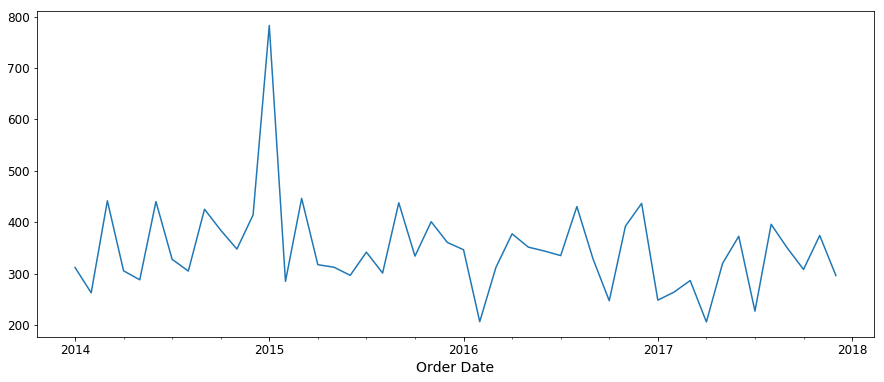

In [88]:
y.plot(figsize=(15, 6))
plt.show()

## Check Stationarity of a Time Series

* A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time.

As most of the Time Series models work on the assumption that the time series is stationary. Intuitively, we can say that if a Time series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

 we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
 
    constant mean
    constant variance
    an autocovariance that does not depend on time.


More formally, we can check stationarity using the following:

**Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.  If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [89]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

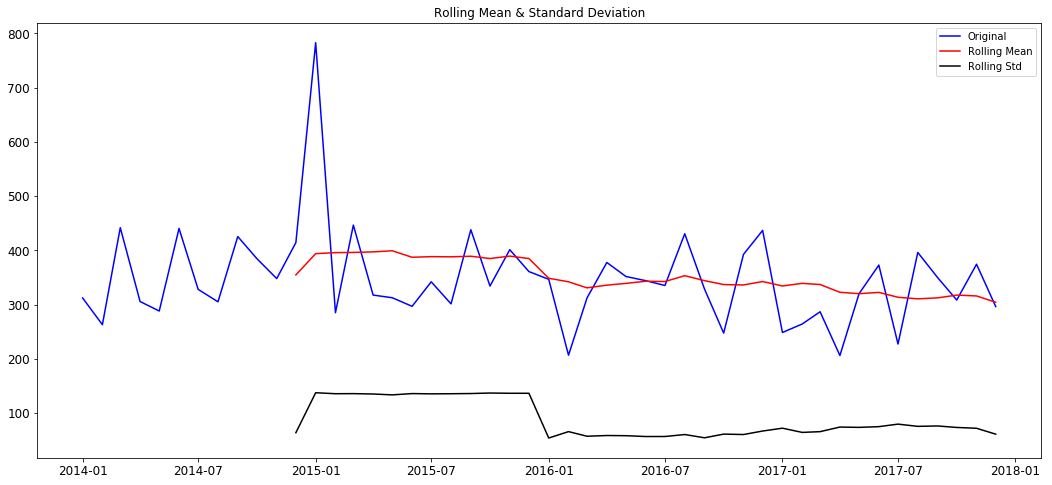

Results of Dickey-Fuller Test:
Test Statistic                -6.962405e+00
p-value                        9.093399e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.700000e+01
Critical Value (1%)           -3.577848e+00
Critical Value (5%)           -2.925338e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


In [90]:
test_stationarity(y)

**The variation in mean is small but there is some inital variation in standard deviation. Also, the test statistic is less than the critical values.**
This is a stationary time series

#### As our time series is stationary .But there was not the case than we have to do something to make time series stationary.

## Eliminating Trend

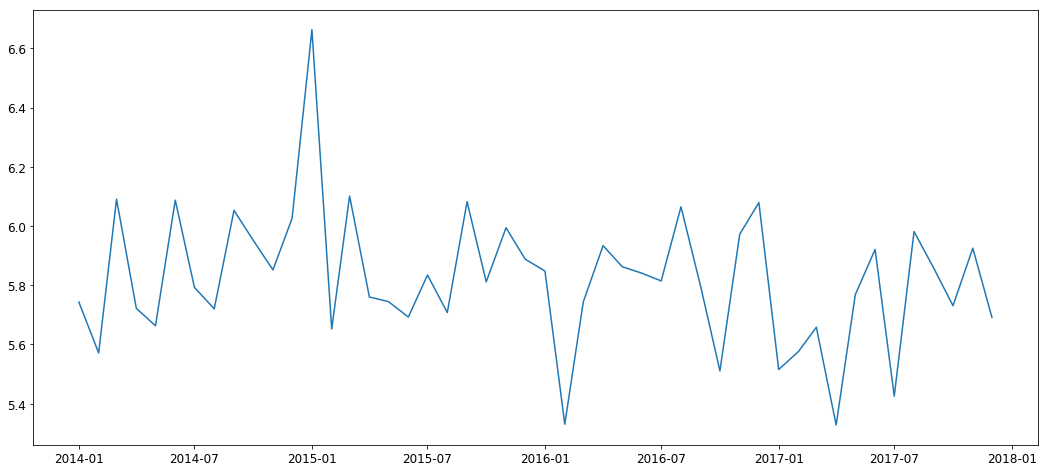

In [91]:
# take a log transform 
y_log = np.log(y)
plt.plot(y_log)
plt.show()

**Moving average**

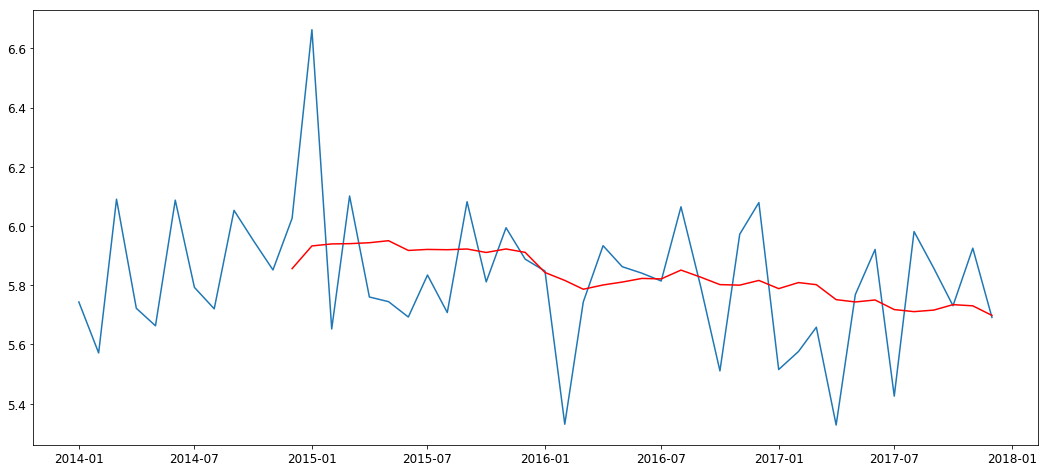

In [92]:
moving_avg = y_log.rolling(12).mean()
plt.plot(y_log)
plt.plot(moving_avg, color='red')
plt.show()

The red line shows the rolling mean. Lets subtract this from the original series.

In [93]:
y_log_moving_avg_diff = y_log - moving_avg
y_log_moving_avg_diff.head(12)

Order Date
2014-01-01         NaN
2014-02-01         NaN
2014-03-01         NaN
2014-04-01         NaN
2014-05-01         NaN
2014-06-01         NaN
2014-07-01         NaN
2014-08-01         NaN
2014-09-01         NaN
2014-10-01         NaN
2014-11-01         NaN
2014-12-01    0.170063
Freq: MS, Name: Sales, dtype: float64

 Lets drop these NaN values and check the plots to test stationarity.

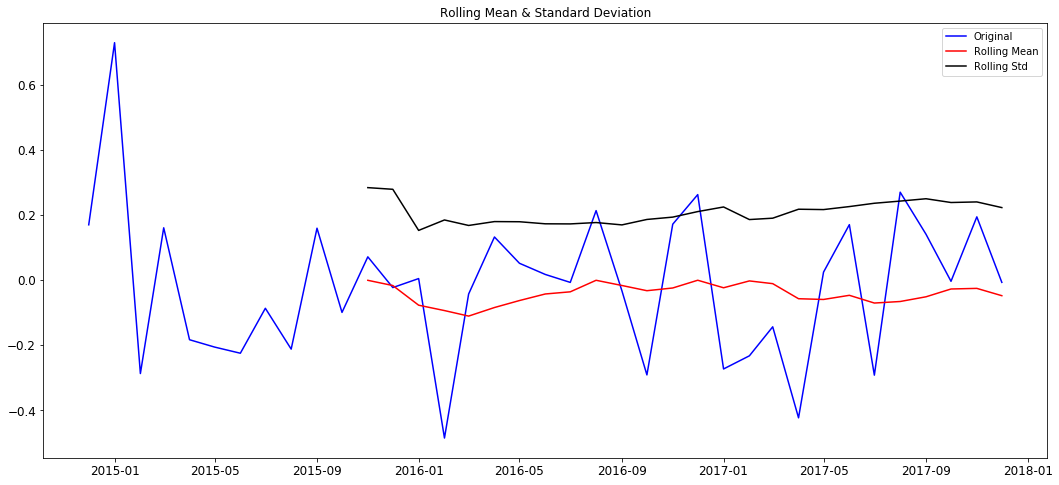

Results of Dickey-Fuller Test:
Test Statistic                -6.221898e+00
p-value                        5.198932e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [94]:
y_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(y_log_moving_avg_diff)

The test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

## Decomposition of Time Series

Time series decomposition involves thinking of a series as a combination of trend, seasonality, and noise components.

**Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.**

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

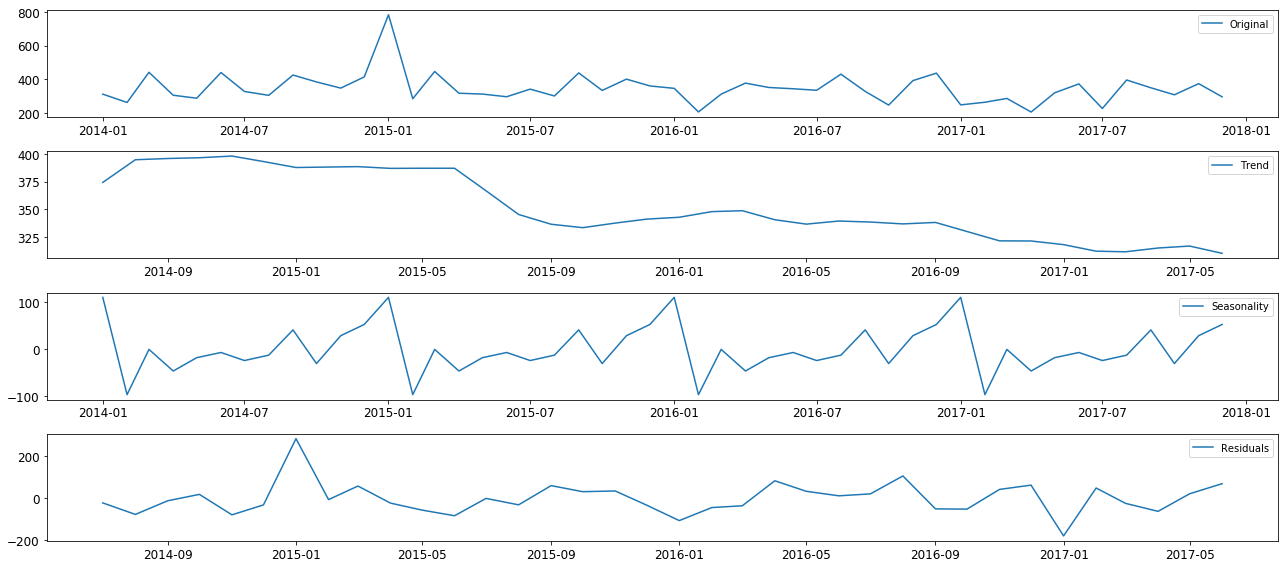

In [96]:
rcParams['figure.figsize'] = 18, 8
plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.**

## Time series forecasting with ARIMA

**ARIMA**, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

    Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
    Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
    Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

    Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
    Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


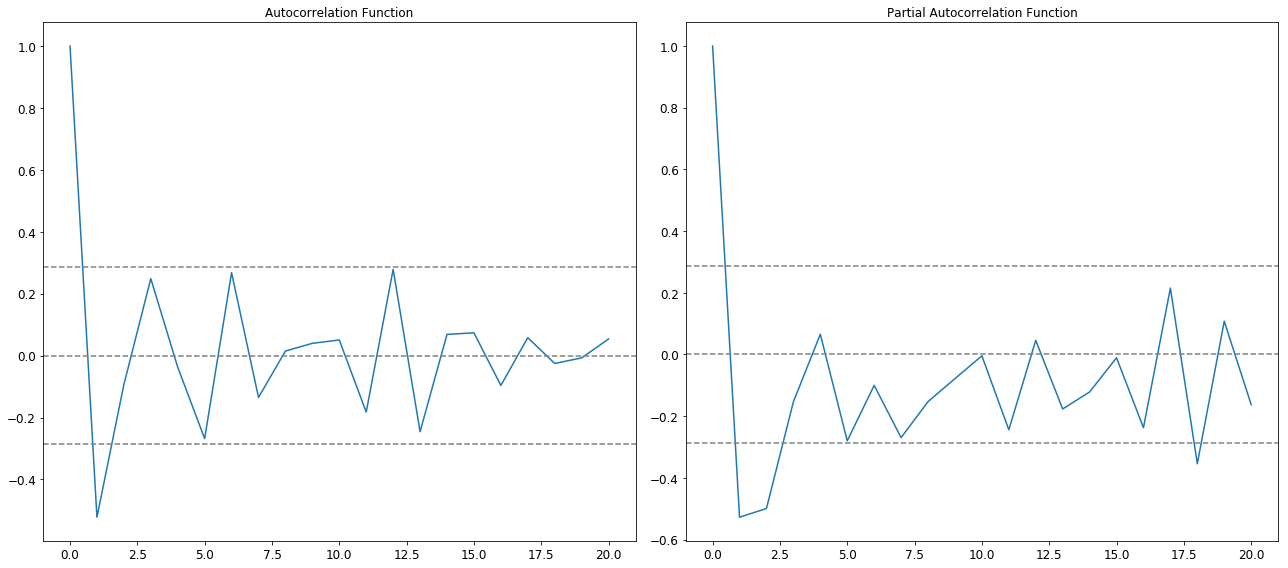

In [97]:
# differencing
y_log_diff = y_log - y_log.shift()
y_log_diff.dropna(inplace=True)

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(y_log_diff, nlags=20)
lag_pacf = pacf(y_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


    p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If we look closely, in this case p=1.
    q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If we look closely, in this case q=1.


#### Alternate to find optimal (p,d,q)

In [98]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [99]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1574.4377016624842
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.1756110053324
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.4464564722349
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680665866
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3377.4221676565053
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.54964533646086
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1408287200606
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:411.57777053622135
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662503275
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269639644
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1260.7803020871534
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.3552136734719
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1477.8674640467575
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.11584524769466


**The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 263.9371. Therefore we should consider this to be optimal option.**

## Fitting the ARIMA model

In [100]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.259     -0.298      0.766      -0.584       0.430
ma.L1         -1.0000      0.434     -2.305      0.021      -1.850      -0.150
ar.S.L12      -0.0007      0.029     -0.025      0.980      -0.057       0.056
sigma2      6323.9743   6.86e-05   9.22e+07      0.000    6323.974    6323.974


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, some weight has a p-value lower or close to 0.05, so it is reasonable to retain  them in our model.


When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

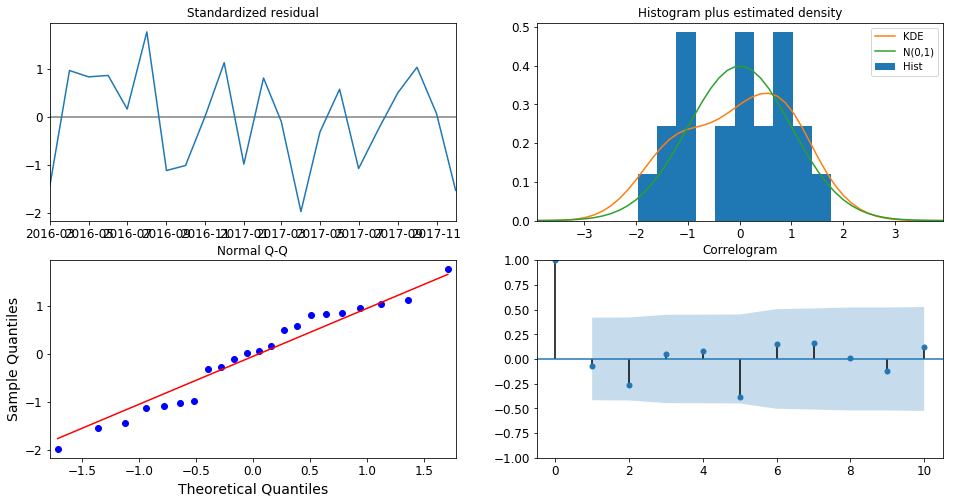

In [101]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a fine indication that the residuals are normally distributed.

    The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

    The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have  correlation with lagged versions of itself.


##  Validating Forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

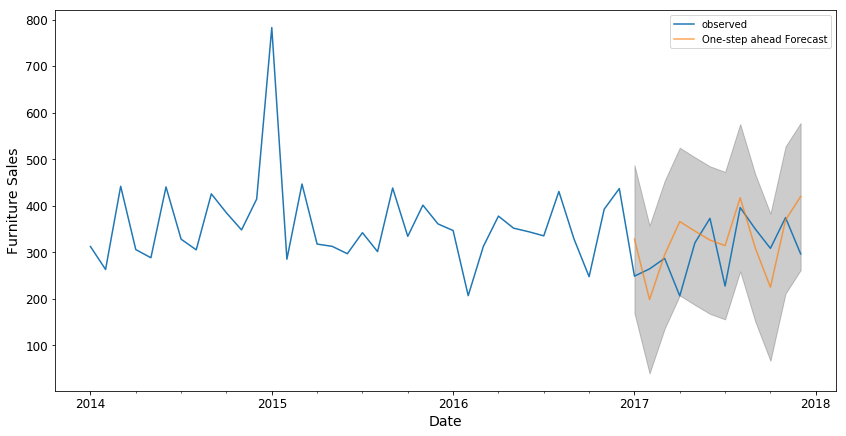

In [102]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [103]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 5911.26


In [104]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 76.88


**Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 76.88 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.**